In [1]:
import numpy as np
import pandas as pd

In [2]:
import kagglehub
path = kagglehub.dataset_download("hellbuoy/car-price-prediction")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'car-price-prediction' dataset.
Path to dataset files: /kaggle/input/car-price-prediction


In [3]:
!mv /root/.cache/kagglehub/datasets/hellbuoy/car-price-prediction/versions/1 /content/dataset

mv: cannot stat '/root/.cache/kagglehub/datasets/hellbuoy/car-price-prediction/versions/1': No such file or directory


In [4]:
car_price_assignment = pd.read_csv('/content/dataset/CarPrice_Assignment.csv')

In [5]:
car_price_assignment

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [6]:
car_price_assignment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [7]:
car_price_assignment['brand'] = car_price_assignment['CarName'].str.lower().str.split().str[0]
car_price_assignment['brand'] = car_price_assignment['brand'].replace({
    'maxda': 'mazda',
    'porcshce': 'porsche',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen'
})
car_price_assignment.drop(['car_ID', 'CarName'], axis=1, inplace=True)
cat_cols = ['fueltype', 'aspiration', 'doornumber', 'carbody',
            'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber',
            'fuelsystem', 'brand']
cars_encoded = pd.get_dummies(car_price_assignment, columns=cat_cols, drop_first=True)
cars_encoded = cars_encoded.astype(float)
X_raw = cars_encoded.drop('price', axis=1).values
y_raw = cars_encoded['price'].values

In [8]:
class LinearRegressionHandled:
    def __init__(self):
        self.weights = None
        self.bias = None
        self.feature_names = None

    def fit(self, X, y):
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        try:
            theta = np.linalg.inv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(X_with_bias) @ y
        self.bias = theta[0]
        self.weights = theta[1:]

    def predict(self, X):
        if self.weights is None:
            raise ValueError("model is not teached")
        return X @ self.weights + self.bias

    def score(self, X, y):
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot)

In [9]:
cars_corr = cars_encoded.copy()
corr_with_price = cars_corr.corr()['price'].abs().sort_values(ascending=False)
top_features = corr_with_price.index[1:16]
X = cars_corr[top_features].values
y = cars_corr['price'].values

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegressionHandled()
model.fit(X_train, y_train)

r2 = model.score(X_test, y_test)
y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

print(f"r2: {r2:.4f}")
print(f"rmse: ${rmse:,.2f}")

r2: 0.8520
rmse: $3,418.20


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, median_absolute_error
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

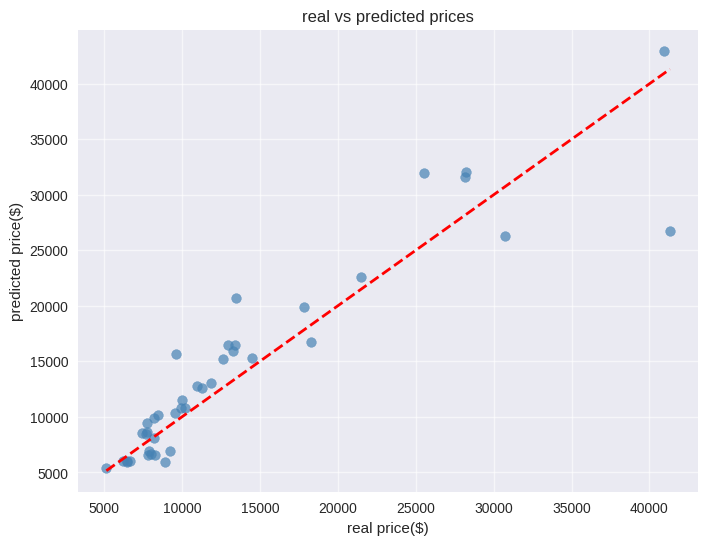

In [12]:
y_pred = model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('real price($)')
plt.ylabel('predicted price($)')
plt.title('real vs predicted prices')
plt.grid(True, alpha=0.6)
plt.show()